In [21]:
import json
from pprint import pprint
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from more_itertools import batched
from torch.utils.data import (
    DataLoader,
    Dataset,
)
from transformers import (
    AutoTokenizer,
    AutoModel,
    LongformerTokenizerFast,
    LongformerModel,
    AutoImageProcessor,
    ResNetModel,
    ResNetConfig,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
)
from tqdm import tqdm
from accelerate.utils import set_seed
from accelerate import Accelerator, notebook_launcher

In [22]:
DATASET_DIR = Path('/kaggle/input/dataset-v1-1')

DATA_DIR = Path('/kaggle/input/windows-pe-dataset')
MODEL_DIR = Path('/kaggle/working/') / 'model'
MODEL_DIR.mkdir(exist_ok=True, parents=True)

EXE_DIR = DATA_DIR / 'pe' / 'pe'
MALWARE_EXE_DIR = EXE_DIR / 'malware'
BENIGN_EXE_DIR = EXE_DIR / 'benign'

CHECKPOINTS_DIR = Path('/kaggle/working/') / 'checkpoints'
CHECKPOINTS_DIR.mkdir(exist_ok=True, parents=True)

RANDOM_STATE = 741

TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 3
TEST_BATCH_SIZE = 3

LEARNING_RATE = 2e-5

#DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

LIMIT_NUM_MODELS = 2
N_EPOCHS = 15

In [23]:
df_train = pd.read_parquet(DATASET_DIR / 'df_train_chunks.parquet')
df_valid = pd.read_parquet(DATASET_DIR / 'df_valid_chunks.parquet')
df_test = pd.read_parquet(DATASET_DIR / 'df_test_chunks.parquet')

In [24]:
class MalwareDetectionModel(torch.nn.Module):
    def __init__(
            self,
            num_classes: int = 2,
    ) -> None:
        super(MalwareDetectionModel, self).__init__()
        resnet_config = ResNetConfig(
            num_channels=1,
            torch_dtype=torch.float32,
            depths=[2, 2, 2, 2],
            hidden_sizes=[64, 128, 256, 512],
            layer_type='basic',
            model_type='resnet',
        )
        self.resnet_model = ResNetModel(resnet_config)
        self.longformer_model = AutoModel.from_pretrained('kazzand/ru-longformer-tiny-16384')

        in_features = self.resnet_model.config.hidden_sizes[-1] + self.longformer_model.config.hidden_size

        self.linear = torch.nn.Linear(in_features, 312)
        self.fc = torch.nn.Linear(312, num_classes)


    def forward(
            self,
            longformer_input_ids,
            longformer_attention_mask,
            longformer_global_attention_mask,
            resnet_pixel_values,
    ):
        resnet_pooler_output = self.resnet_model(pixel_values=resnet_pixel_values).pooler_output
        resnet_flatten_pooler_output = resnet_pooler_output.flatten(start_dim=1)

        longformer_pooler_output = self.longformer_model(
            input_ids=longformer_input_ids,
            attention_mask=longformer_attention_mask,
            global_attention_mask=longformer_global_attention_mask,
        ).pooler_output


        concated_outputs = torch.concat([resnet_flatten_pooler_output, longformer_pooler_output], dim=1)
        logits = torch.relu(self.linear(concated_outputs))
        logits = self.fc(logits)
        return logits


In [25]:
preprocess_config = '''
{
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": 0.356,
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": 0.332,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}
'''

with open(MODEL_DIR / 'preprocessor_config.json', 'w') as f:
    f.write(preprocess_config)

In [26]:
class MalwareDetectionDataset(Dataset):
    def __init__(
            self,
            df: pd.DataFrame,
            image_processor: Union[str, Path] = MODEL_DIR,
            longformer_tokenizer: Union[str, Path] = 'kazzand/ru-longformer-tiny-16384',
            with_hashes: bool = False,
    ):
        super(MalwareDetectionDataset, self).__init__()
        self._df = df
        
        self.with_hashes = with_hashes
        self.image_processor = AutoImageProcessor.from_pretrained(image_processor)
        self.longformer_tokenizer = LongformerTokenizerFast.from_pretrained(longformer_tokenizer)

    def __len__(self):
        return self._df.shape[0]

    def __getitem__(self, item):
        row = self._df.iloc[item]

        if row.LABEL == 'malware':
            exe_path = MALWARE_EXE_DIR
        elif row.LABEL == 'benign':
            exe_path = BENIGN_EXE_DIR
        else:
            raise NotImplementedError()

        exe_file = exe_path / f'{row.HASH}.exe'
        if not exe_file.exists():
            exe_file = exe_path / f'{row.HASH}.ole'

        with exe_file.open('rb') as _file:
            data = list(_file.read(224 * 224))

        padding = [0] * (224*224 - len(data))
        data.extend(padding)

        img = torch.reshape(
            input=torch.tensor(data, dtype=torch.uint8),
            shape=(1, 224, 224),
        )
        pixel_values = self.image_processor(img, return_tensors="pt").pixel_values

        # NLP
        inputs = self.longformer_tokenizer(
            row.TEXT,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=16_384,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        global_attention_mask = [
            [1 if token_id == self.longformer_tokenizer.cls_token_id else 0 for token_id in input_ids]
            for input_ids in inputs["input_ids"]
        ]

        inputs["global_attention_mask"] = torch.tensor(global_attention_mask)


        result = {
            'longformer_input_ids': inputs['input_ids'].flatten(),
            'longformer_attention_mask': inputs['attention_mask'].flatten(),
            'longformer_global_attention_mask': inputs['global_attention_mask'].flatten(),
            'resnet_pixel_values': pixel_values.flatten(1, 2),
            'labels': torch.tensor(row.LABEL_ID, dtype=torch.long),
        }
        
        if self.with_hashes:
            result['hash'] = row.HASH
        
        return result


In [27]:
train_dataset = MalwareDetectionDataset(df_train)
valid_dataset = MalwareDetectionDataset(df_valid)
test_dataset = MalwareDetectionDataset(df_test, with_hashes=True)

In [28]:
def training_loop(
    mixed_precision: str = "fp16",
    random_state: int = RANDOM_STATE,
    batch_size: int = TRAIN_BATCH_SIZE,
    n_epochs: int = N_EPOCHS,
):
    set_seed(random_state)
    
    accelerator = Accelerator(mixed_precision=mixed_precision)
    
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        generator=torch.manual_seed(random_state),
        shuffle=True,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        generator=torch.manual_seed(random_state),
        shuffle=True,
    )
    
    with accelerator.main_process_first():
        model = MalwareDetectionModel(num_classes=2)
    
    
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                     T_0=8,
                                                                     T_mult=1,
                                                                     eta_min=1e-7)
    
    (model,
     optimizer,
     train_dataloader,
     valid_dataloader,
     scheduler) = accelerator.prepare(model,
                                      optimizer,
                                      train_dataloader,
                                      valid_dataloader,
                                      scheduler)
    
    loss_stats = {
        'train': [],
        'valid': [],
    }

    min_valid_loss = float('inf')
    saved_model_paths = []
    
    for epoch in range(1, n_epochs):
        model.train()
        train_loss = []
        for batch in train_dataloader:
            optimizer.zero_grad()
            labels = batch["labels"]
            del batch["labels"]
            logits = model(**batch)
            loss = torch.nn.functional.cross_entropy(logits, labels)
            
            accelerator.backward(loss)
            
            optimizer.step()
            scheduler.step()
            
            train_loss.append(loss.item())
            
        model.eval()
        valid_loss = []
        for batch in valid_dataloader:
            with torch.no_grad():
                labels = batch["labels"]
                del batch["labels"]
                logits = model(**batch)
                loss = torch.nn.functional.cross_entropy(logits, labels)
                
                valid_loss.append(loss.item())
        
        loss_stats['train'].append(np.mean(train_loss))
        loss_stats['valid'].append(np.mean(valid_loss))
        
        if loss_stats['valid'][-1] < min_valid_loss:
            min_valid_loss = loss_stats['valid'][-1]

            model_name = CHECKPOINTS_DIR / f'model-{epoch}-epoch.pt'
            
            accelerator.wait_for_everyone() 
            unwrapped_model = accelerator.unwrap_model(model)
            accelerator.save(unwrapped_model,  str(model_name))
            accelerator.print(f'Saved model: {model_name}')


            saved_model_paths.append(model_name)
        
        accelerator.print(f'''{'EPOCH: ' + str(epoch):-^50}''')
        accelerator.print(f'''Loss:''')
        accelerator.print(f'''    Train: {loss_stats['train'][-1]:.5f}''')
        accelerator.print(f'''    Valid: {loss_stats['valid'][-1]:.5f}''')
        accelerator.print('-' * 50, end='\n\n')

In [29]:
notebook_launcher(training_loop, num_processes=2)

Launching training on 2 GPUs.


Some weights of LongformerModel were not initialized from the model checkpoint at kazzand/ru-longformer-tiny-16384 and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LongformerModel were not initialized from the model checkpoint at kazzand/ru-longformer-tiny-16384 and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saved model: /kaggle/working/checkpoints/model-1-epoch.pt
---------------------EPOCH: 1---------------------
Loss:
    Train: 0.13409
    Valid: 0.02188
--------------------------------------------------

Saved model: /kaggle/working/checkpoints/model-2-epoch.pt
---------------------EPOCH: 2---------------------
Loss:
    Train: 0.02346
    Valid: 0.00481
--------------------------------------------------

Saved model: /kaggle/working/checkpoints/model-3-epoch.pt
---------------------EPOCH: 3---------------------
Loss:
    Train: 0.01045
    Valid: 0.00189
--------------------------------------------------

---------------------EPOCH: 4---------------------
Loss:
    Train: 0.00668
    Valid: 0.00466
--------------------------------------------------



KeyboardInterrupt: 

In [31]:
model = torch.load('/kaggle/working/checkpoints/model-3-epoch.pt')
model = model.to('cuda:0')

In [32]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    generator=torch.manual_seed(RANDOM_STATE),
    shuffle=False,
)

In [33]:
pred_labels_list = []
true_labels_list = []
hashes = []

model.eval()
with torch.inference_mode():
    for batch in tqdm(test_dataloader, 'TEST'):
        labels = batch['labels']
        batch_hashes = batch['hash']
        del batch['labels']
        del batch['hash']
        batch = {key: value.to('cuda:0') for key, value in batch.items()}

        logits = model(**batch)

        pred_labels_list.extend(logits.detach().cpu().argmax(-1).tolist())
        true_labels_list.extend(labels.tolist())
        hashes.extend(batch_hashes)

TEST: 100%|██████████| 577/577 [12:38<00:00,  1.31s/it]


In [34]:
df_result = pd.DataFrame(
    {
        'HASH': hashes,
        'LABEL': true_labels_list,
        'PRED': pred_labels_list,
    }
)

In [35]:
df_filtered = df_result.groupby(by='HASH').max()

In [36]:
print(classification_report(df_filtered.LABEL.to_numpy(), df_filtered.PRED.to_numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       224
           1       1.00      1.00      1.00      1001

    accuracy                           1.00      1225
   macro avg       1.00      1.00      1.00      1225
weighted avg       1.00      1.00      1.00      1225



In [37]:
accuracy_score(df_filtered.LABEL.to_numpy(), df_filtered.PRED.to_numpy())

0.9991836734693877

In [38]:
f1_score(df_filtered.LABEL.to_numpy(), df_filtered.PRED.to_numpy())

0.9995002498750626

In [39]:
cm = confusion_matrix(df_filtered.LABEL.to_numpy(), df_filtered.PRED.to_numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

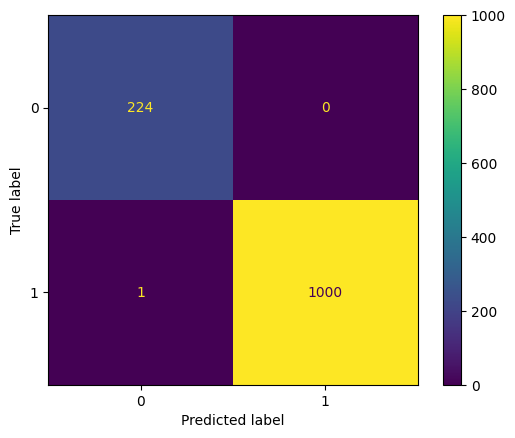

In [40]:
disp.plot()

In [41]:
torch.save(model.state_dict(), '/kaggle/working/pytorch_model.bin')